1. Building a decision tree to classify flowers using DecisionTreeClasifier

In [46]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Load the iris data
iris = load_iris()
X = iris.data
y = iris.target

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42 , stratify=y
)

# Initialize depths and model storage
depths = [1, 2, 3]
models = {}

# Train and evaluate models
for depth in depths:
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_clf.fit(X_train, y_train)
    models[depth] = tree_clf

    train_acc = tree_clf.score(X_train, y_train)
    test_acc = tree_clf.score(X_test, y_test)

    print(f"Depth {depth} -> Train Accuracy: {train_acc:.3f} | Test Accuracy: {test_acc:.3f}")




Depth 1 -> Train Accuracy: 0.667 | Test Accuracy: 0.667
Depth 2 -> Train Accuracy: 0.971 | Test Accuracy: 0.889
Depth 3 -> Train Accuracy: 0.981 | Test Accuracy: 0.978



2. Using KNN to classify flowers

k=1 -> Train Accuracy: 0.943 | Test Accuracy: 0.711
k=3 -> Train Accuracy: 0.867 | Test Accuracy: 0.667
k=5 -> Train Accuracy: 0.857 | Test Accuracy: 0.822
k=10 -> Train Accuracy: 0.810 | Test Accuracy: 0.756


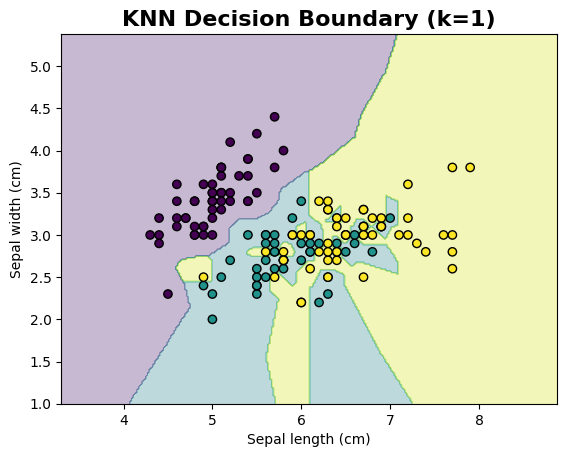

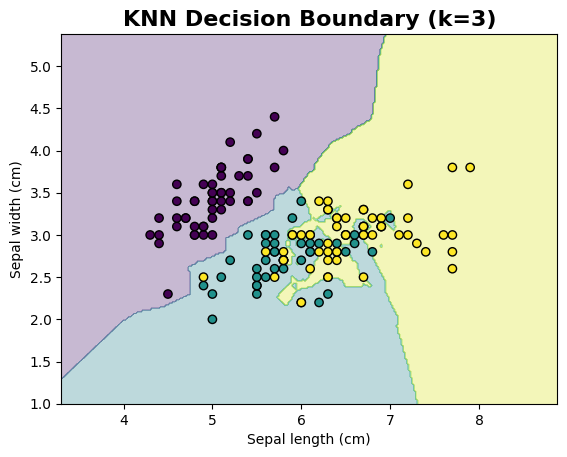

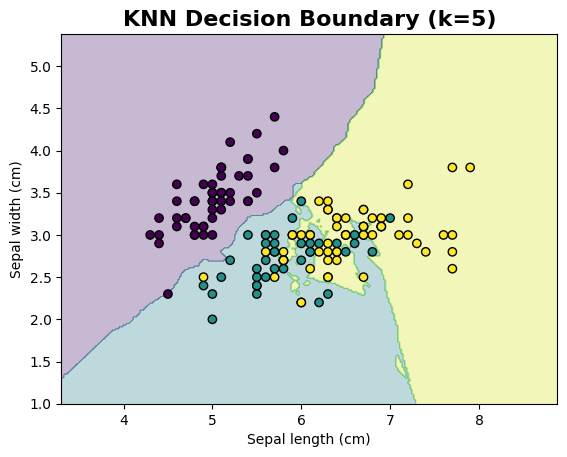

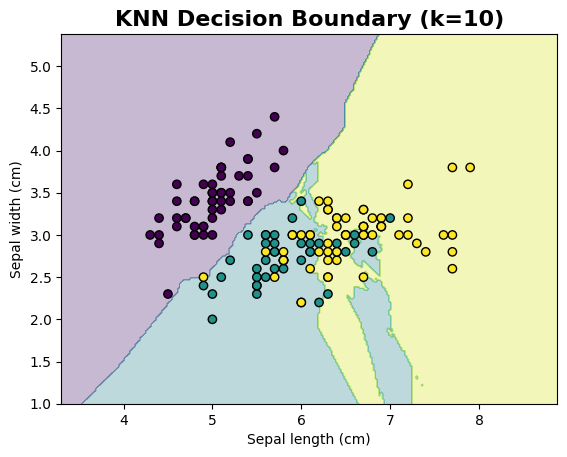

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load the iris data
iris = load_iris()

# Selecting the data
X = iris.data[:, :2]                                                       # sepal length and width
y = iris.target                                                            # the target flowers

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize neighbors and model storage
k_neighbors = [1, 3, 5, 10]
models = {}

# Train models and print accuracy
for k_neighbor in k_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k_neighbor)
    knn.fit(X_train, y_train)
    models[k_neighbor] = knn

    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)

    print(f"k={k_neighbor} -> Train Accuracy: {train_acc:.3f} | Test Accuracy: {test_acc:.3f}")


# Create mesh grid (shared for all plots)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.02),
    np.arange(y_min, y_max, 0.02)
)

for k_neighbor in k_neighbors:
    # Train model
    knn = KNeighborsClassifier(n_neighbors=k_neighbor)
    knn.fit(X, y)

    # Predict over grid
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
    plt.title(f"KNN Decision Boundary (k={k_neighbor})",  fontsize=16, fontweight='bold')
    plt.xlabel("Sepal length (cm)", )
    plt.ylabel("Sepal width (cm)")
    plt.show()



3. Confusion Matrix, Accuracy, Precision, Recall, F1


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.94      1.00      0.97        15
   virginica       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



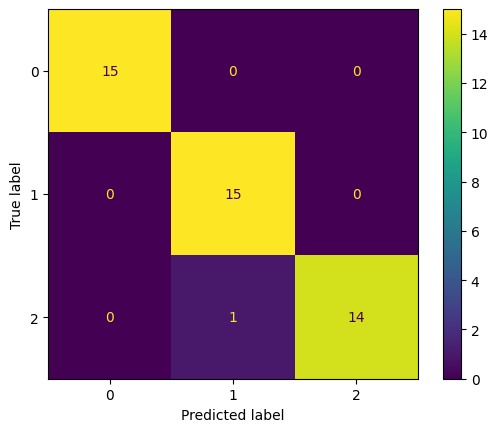

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

# Load the iris data
iris = load_iris()

# Selecting the data
X = iris.data                                                       # sepal and petal length and width
y = iris.target                                                            # the target flowers

# Train/ Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict on the same data
y_pred  = knn.predict(X_test)

# Classification report (accuracy, precision, recall, F1)
print(classification_report(y_test, y_pred, target_names=iris.target_names))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)





4. ROC-AUC Curve

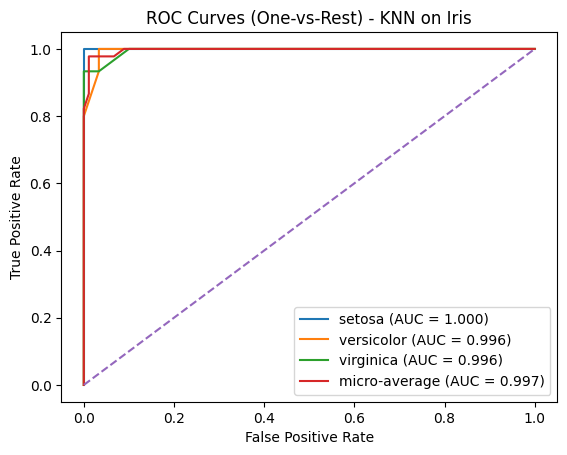

AUC for setosa: 1.000
AUC for versicolor: 0.996
AUC for virginica: 0.996
Micro-average AUC: 0.997


In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

# ROC + AUC (multiclass: One-vs-Rest)

n_classes = len(iris.target_names)

# Binarize the test labels for ROC
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Wrap KNN in One-vs-Rest so we can get per-class probability scores
knn_ovr = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
knn_ovr.fit(X_train, y_train)

# Probability scores for each class
y_score = knn_ovr.predict_proba(X_test)  # shape: (n_samples, n_classes)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC + AUC (overall)
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()
for i, name in enumerate(iris.target_names):
    plt.plot(fpr[i], tpr[i], label=f"{name} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest) - KNN on Iris")
plt.legend(loc="lower right")
plt.show()

# Print AUC values
for i, name in enumerate(iris.target_names):
    print(f"AUC for {name}: {roc_auc[i]:.3f}")
print(f"Micro-average AUC: {roc_auc['micro']:.3f}")
